News Dataset:
                                                 Link  \
0  https://edition.cnn.com/2023/09/29/business/st...   
1  https://www.channelnewsasia.com/singapore/su-w...   
2  https://edition.cnn.com/2023/05/22/tech/meta-f...   
3  https://www.channelnewsasia.com/singapore/bill...   
4  https://edition.cnn.com/2024/03/05/politics/li...   

                                                Text  content_length language  \
0  Starbucks violated federal labor law when it i...             680       en   
1  The first suspect to plead guilty in Singapore...             740       en   
2  Meta has been fined a record-breaking €1.2 bil...             891       en   
3  SINGAPORE: A 45-year-old man linked to Singapo...             602       en   
4  The Department of Education imposed a record $...             850       en   

   valid_format  accessible  \
0          True         NaN   
1          True         NaN   
2          True         NaN   
3          True         NaN   
4     

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


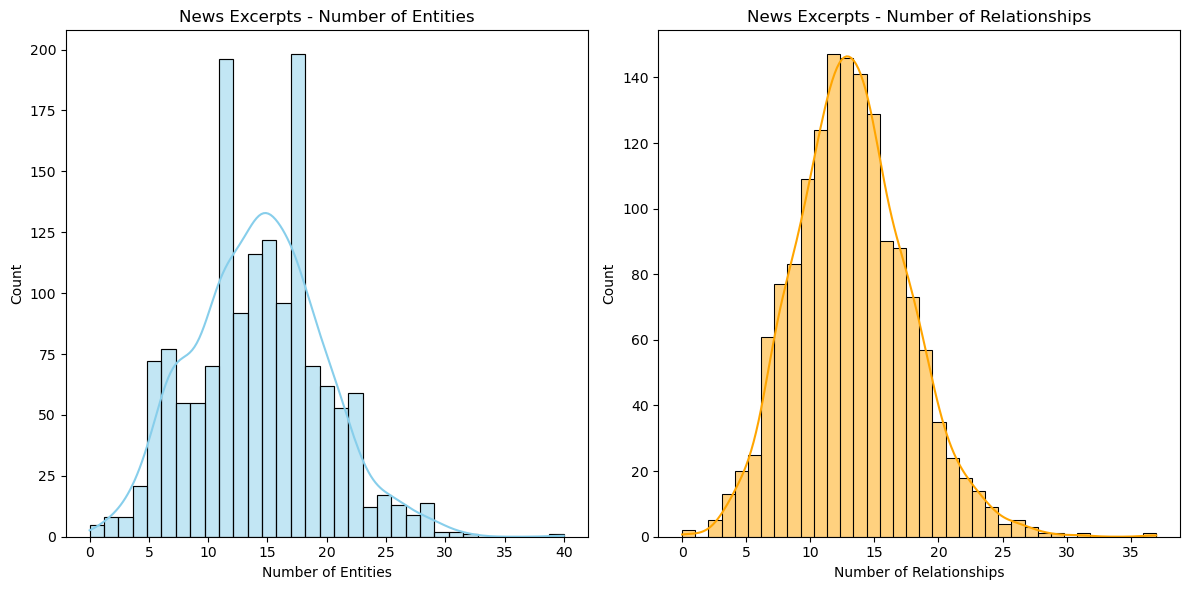

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


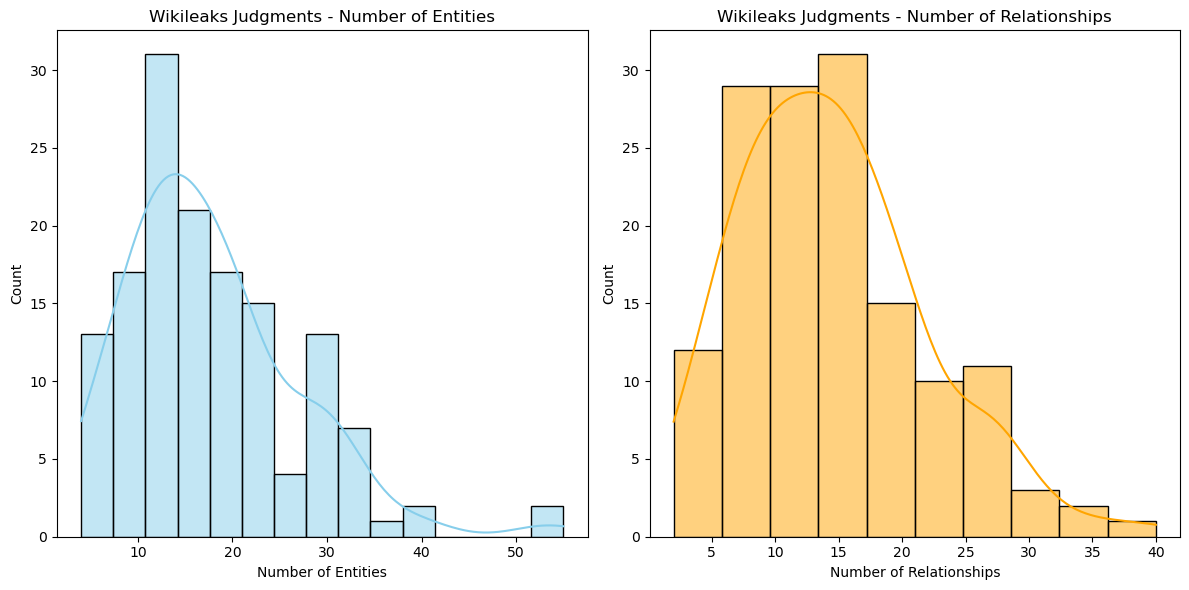

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load the datasets
news_df = pd.read_excel("entity_SA_newsexcerpt.xlsx")
wikileaks_df = pd.read_excel("entity_SA_wikileaks.xlsx")

# Data overview
print("News Dataset:\n", news_df.head())
print("Wikileaks Dataset:\n", wikileaks_df.head())

# Summarize the number of entities and relationships
def summarize_data(df, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.histplot(df['num_entities'], kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"{title} - Number of Entities")
    axes[0].set_xlabel("Number of Entities")
    
    sns.histplot(df['num_relationships'], kde=True, ax=axes[1], color="orange")
    axes[1].set_title(f"{title} - Number of Relationships")
    axes[1].set_xlabel("Number of Relationships")
    
    plt.tight_layout()
    plt.show()

summarize_data(news_df, "News Excerpts")
summarize_data(wikileaks_df, "Wikileaks Judgments")




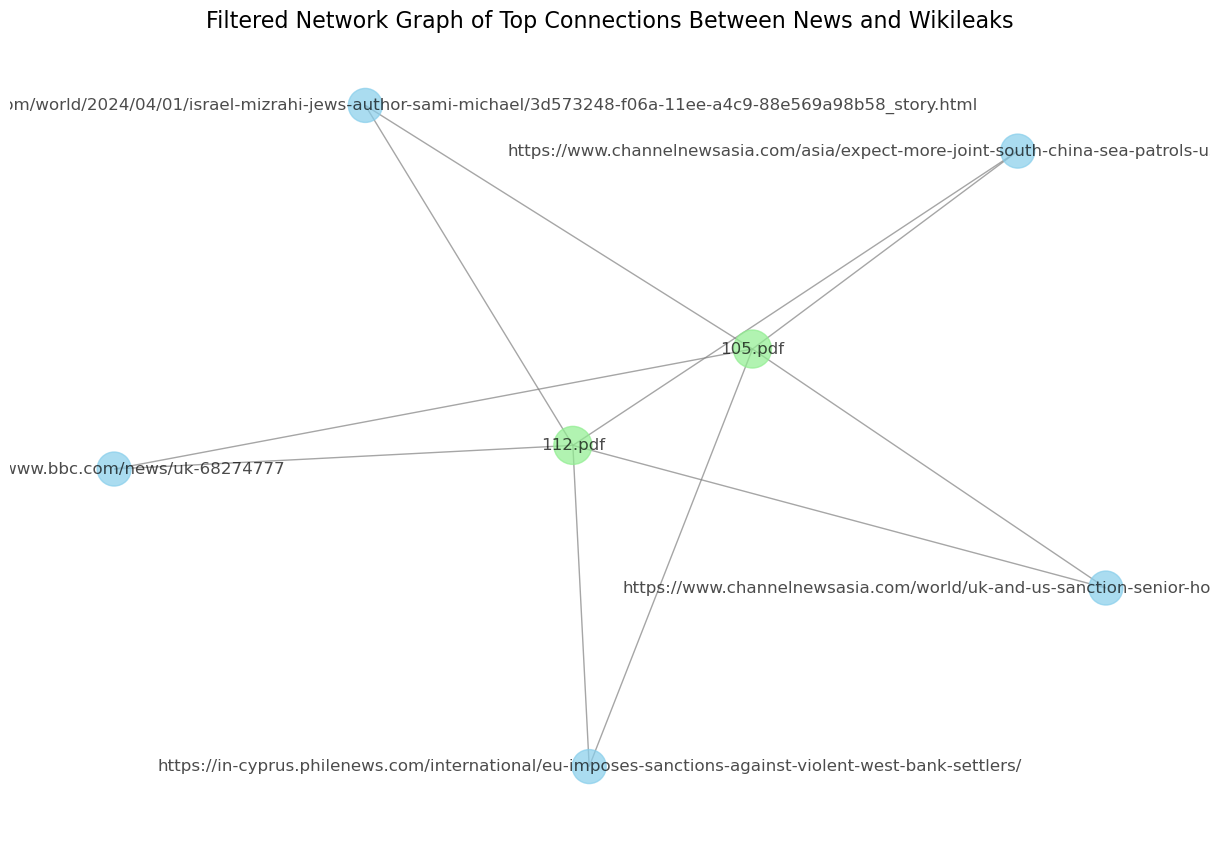

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load the Excel files
news_df = pd.read_excel("entity_SA_newsexcerpt.xlsx")
wikileaks_df = pd.read_excel("entity_SA_wikileaks.xlsx")

# Extract entities
news_entities = news_df['entities'].str.split(',').explode()
wikileaks_entities = wikileaks_df['entities'].str.split(',').explode()

# Count most common entities in both datasets
news_entity_counts = Counter(news_entities.dropna())
wikileaks_entity_counts = Counter(wikileaks_entities.dropna())

# Select the top 10 entities from each dataset
common_news_entities = set([entity for entity, _ in news_entity_counts.most_common(10)])
common_wikileaks_entities = set([entity for entity, _ in wikileaks_entity_counts.most_common(10)])

# Filter rows to only include rows with top entities
news_df_filtered = news_df[news_df['entities'].apply(lambda x: any(e in x for e in common_news_entities) if pd.notnull(x) else False)]
wikileaks_df_filtered = wikileaks_df[wikileaks_df['entities'].apply(lambda x: any(e in x for e in common_wikileaks_entities) if pd.notnull(x) else False)]

# Create a graph
G = nx.Graph()

# Add nodes for news articles and Wikileaks judgments
for _, row in news_df_filtered.iterrows():
    G.add_node(row['Link'], type='news')

for _, row in wikileaks_df_filtered.iterrows():
    G.add_node(row['PDF Path'], type='wikileaks')

# Add edges for shared entities with weights
for _, news_row in news_df_filtered.iterrows():
    for _, wiki_row in wikileaks_df_filtered.iterrows():
        news_entities = set(news_row['entities'].split(',')) if pd.notnull(news_row['entities']) else set()
        wiki_entities = set(wiki_row['entities'].split(',')) if pd.notnull(wiki_row['entities']) else set()
        common_entities = news_entities & wiki_entities
        if common_entities:
            G.add_edge(news_row['Link'], wiki_row['PDF Path'], weight=len(common_entities))

# Identify the top 5 weighted edges to create a cleaner graph
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
top_edge_nodes = set([u for u, v, _ in top_edges] + [v for u, v, _ in top_edges])

# Create a subgraph with the top edges
subgraph = G.subgraph(top_edge_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 8))

# Define node colors based on type
node_colors = ["skyblue" if subgraph.nodes[node]['type'] == 'news' else "lightgreen" for node in subgraph]

# Define node sizes based on degree
node_sizes = [500 + 50 * subgraph.degree[node] for node in subgraph]

# Draw network
pos = nx.spring_layout(subgraph, seed=42)  # Neat layout
nx.draw(
    subgraph, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color="gray", alpha=0.7
)

plt.title("Filtered Network Graph of Top Connections Between News and Wikileaks", fontsize=16)
plt.show()
